## Project Code

In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.7":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.7":
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.18.5", 'matplotlib': "3.2.2",'sklearn': "0.23.1", 
                'pandas': "1.0.5",'xgboost': "1.1.1", 'shap': "0.35.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]

[ OK ] numpy version 1.18.5 is installed.
[ OK ] matplotlib version 3.2.2 is installed.
[ OK ] sklearn version 0.23.1 is installed.
[ OK ] pandas version 1.0.5 is installed.
[ OK ] xgboost version 1.1.1 is installed.
[ OK ] shap version 0.35.0 is installed.


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import math
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
import xgboost

## For a given national park, given a species of specific nativeness, order and family, can we predict abundance?

**Step 1**

Read data into the cell 

In [3]:
# read in the data in this cell
df1 = pd.read_csv('../data/species.csv', low_memory=False)
df1 = df1.loc[:, df1.columns != 'Unnamed: 13']
# print(df1)

In [4]:
df2 = pd.read_csv('../data/parks.csv')
# print(df2)

In [5]:
df = df1.merge(df2,how='outer',on='Park Name')  # merging on IDs present in any dataframe
df

,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Park Code,State,Acres,Latitude,Longitude
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN,ACAD,ME,47390,44.35,-68.21
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN,ACAD,ME,47390,44.35,-68.21
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,ACAD,ME,47390,44.35,-68.21
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered,ACAD,ME,47390,44.35,-68.21
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,NaN,ACAD,ME,47390,44.35,-68.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119243,ZION-2791,Zion National Park,Vascular Plant,Solanales,Solanaceae,Solanum triflorum,Cut-Leaf Nightshade,Approved,Present,Native,Uncommon,NaN,NaN,ZION,UT,146598,37.30,-113.05
119244,ZION-2792,Zion National Park,Vascular Plant,Vitales,Vitaceae,Vitis arizonica,Canyon Grape,Approved,Present,Native,Uncommon,NaN,NaN,ZION,UT,146598,37.30,-113.05
119245,ZION-2793,Zion National Park,Vascular Plant,Vitales,Vitaceae,Vitis vinifera,Wine Grape,Approved,Present,Not Native,Uncommon,NaN,NaN,ZION,UT,146598,37.30,-113.05
119246,ZION-2794,Zion National Park,Vascular Plant,Zygophyllales,Zygophyllaceae,Larrea tridentata,Creosote Bush,Approved,Present,Native,Rare,NaN,NaN,ZION,UT,146598,37.30,-113.05


In [6]:
# df = df[(df['Record Status']!='Approved')]

df.shape

(119248, 18)

The following columns seem irrelevant to the model: 
1) Species ID



3) Common Names

4) Park Code


In [7]:
df = df.loc[:, df.columns != 'Species ID']
df = df.loc[:, df.columns != 'Common Names']
df = df.loc[:, df.columns != 'Park Code']
df = df.loc[:, df.columns != 'Scientific Name']
# df = df.loc[:, df.columns != 'State']
print(df.shape)

(119248, 14)


In [8]:
# df2 = df[(df['Category']!='Vascular Plant')]
# df2 = df2[(df2['Category']!='Nonvascular Plant')]

In [9]:
# df.dropna(subset=['Abundance'], inplace=True)                  Not dropping, converting to "Missing"
#for x in df['Abundance']:                              # iterates through each value in each column
#    if math.isnan(x)==True:             # if value is NaN and the column index for missing values has not been registered
#        print(i)
#        #col_missing = i
# values = {'Abundance': 'Missing'}      # value = values
df.fillna("Missing", inplace = True)

df.shape
df

,Park Name,Category,Order,Family,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,State,Acres,Latitude,Longitude
0,Acadia National Park,Mammal,Artiodactyla,Cervidae,Approved,Present,Native,Rare,Resident,Missing,ME,47390,44.35,-68.21
1,Acadia National Park,Mammal,Artiodactyla,Cervidae,Approved,Present,Native,Abundant,Missing,Missing,ME,47390,44.35,-68.21
2,Acadia National Park,Mammal,Carnivora,Canidae,Approved,Present,Not Native,Common,Missing,Species of Concern,ME,47390,44.35,-68.21
3,Acadia National Park,Mammal,Carnivora,Canidae,Approved,Not Confirmed,Native,Missing,Missing,Endangered,ME,47390,44.35,-68.21
4,Acadia National Park,Mammal,Carnivora,Canidae,Approved,Present,Unknown,Common,Breeder,Missing,ME,47390,44.35,-68.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119243,Zion National Park,Vascular Plant,Solanales,Solanaceae,Approved,Present,Native,Uncommon,Missing,Missing,UT,146598,37.30,-113.05
119244,Zion National Park,Vascular Plant,Vitales,Vitaceae,Approved,Present,Native,Uncommon,Missing,Missing,UT,146598,37.30,-113.05
119245,Zion National Park,Vascular Plant,Vitales,Vitaceae,Approved,Present,Not Native,Uncommon,Missing,Missing,UT,146598,37.30,-113.05
119246,Zion National Park,Vascular Plant,Zygophyllales,Zygophyllaceae,Approved,Present,Native,Rare,Missing,Missing,UT,146598,37.30,-113.05


In [10]:
df2 = df[(df['Category']!='Vascular Plant')]
df2 = df2[(df2['Category']!='Nonvascular Plant')]
df2.shape

(49749, 14)

1) Relative abundance

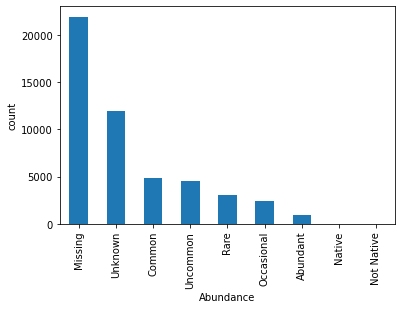

In [11]:
pd.value_counts(df2['Abundance']).plot.bar()
plt.ylabel('count')
plt.xlabel('Abundance')
plt.show()

In [12]:
# df = df[(df['Abundance']=="Uncommon")|(df['Abundance']=="Common")|(df['Abundance']=="Rare")|(df['Abundance']=="Occasional")|(df['Abundance']=="Abundant")]
# print(df.shape)
# print(df[(df['Category']=='Vascular Plant')].shape)
df2 = df2[(df2['Abundance']!='Native')]
df2 = df2[(df2['Abundance']!='Not Native')]
df2.shape
df = df2
df

,Park Name,Category,Order,Family,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,State,Acres,Latitude,Longitude
0,Acadia National Park,Mammal,Artiodactyla,Cervidae,Approved,Present,Native,Rare,Resident,Missing,ME,47390,44.35,-68.21
1,Acadia National Park,Mammal,Artiodactyla,Cervidae,Approved,Present,Native,Abundant,Missing,Missing,ME,47390,44.35,-68.21
2,Acadia National Park,Mammal,Carnivora,Canidae,Approved,Present,Not Native,Common,Missing,Species of Concern,ME,47390,44.35,-68.21
3,Acadia National Park,Mammal,Carnivora,Canidae,Approved,Not Confirmed,Native,Missing,Missing,Endangered,ME,47390,44.35,-68.21
4,Acadia National Park,Mammal,Carnivora,Canidae,Approved,Present,Unknown,Common,Breeder,Missing,ME,47390,44.35,-68.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117880,Zion National Park,Fish,Salmoniformes,Salmonidae,Approved,Present,Not Native,Occasional,Breeder,Missing,UT,146598,37.30,-113.05
117881,Zion National Park,Fish,Salmoniformes,Salmonidae,Approved,Present,Not Native,Unknown,Breeder,Missing,UT,146598,37.30,-113.05
117882,Zion National Park,Fish,Salmoniformes,Salmonidae,Approved,Present,Not Native,Uncommon,Breeder,Missing,UT,146598,37.30,-113.05
117883,Zion National Park,Fish,Salmoniformes,Salmonidae,Approved,Present,Not Native,Occasional,Breeder,Missing,UT,146598,37.30,-113.05


In [13]:
print("Park Name: ", pd.unique(df2['Park Name']).shape[0])
print("Category: ", pd.unique(df2['Category']).shape[0])
print("Order: ", pd.unique(df2['Order']).shape[0])
print("Family: ", pd.unique(df2['Family']).shape[0])

Park Name:  56
Category:  12
Order:  412
Family:  1869


In [14]:
#print("Scientific Names: ", pd.unique(df2['Scientific Name']).shape[0])

In [15]:
df = df2

In [16]:
print(df.columns)

Index(['Park Name', 'Category', 'Order', 'Family', 'Record Status',
       'Occurrence', 'Nativeness', 'Abundance', 'Seasonality',
       'Conservation Status', 'State', 'Acres', 'Latitude', 'Longitude'],
      dtype='object')


In [17]:
y = df2['Abundance'] 
X = df2.loc[:, df2.columns != 'Abundance'] # all other columns are features
z = df2['Park Name']

X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=z,random_state=42)   # first split
print('training set:',X_train.shape, y_train.shape)                           # 60% of points are in train
# z = X_train['Park Name']
# print(z.value_counts(normalize=True))

z_other = X_other['Park Name']
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=z_other,random_state=42)  # second split
print('validation set:',X_val.shape, y_val.shape)                             # 20% of points are in validation
print('test set:',X_test.shape, y_test.shape)                                 # 20% of points are in test
# z_other = X_other['Park Name']
# print(z.value_counts(normalize=True))

ct = ColumnTransformer(
    [("ohe", OneHotEncoder, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
     ("ss", StandardScaler, [11, 12])
    ])

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)


## Data Preprocessing

In [18]:
y = df2['Abundance'] 
X = df2.loc[:, df2.columns != 'Abundance'] # all other columns are features
z = df2['Park Name']

X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=z,random_state=42)   # first split
print('training set:',X_train.shape, y_train.shape)                           # 60% of points are in train
# z = X_train['Park Name']
# print(z.value_counts(normalize=True))

z_other = X_other['Park Name']
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=z_other,random_state=42)  # second split
print('validation set:',X_val.shape, y_val.shape)                             # 20% of points are in validation
print('test set:',X_test.shape, y_test.shape)                                 # 20% of points are in test
# z_other = X_other['Park Name']
# print(z.value_counts(normalize=True))

# preprocess categorical variables - used OneHotEncoder
onehot_ftrs = ['Park Name', 'Category', 'Order', 'Family', 'Record Status', 'Occurrence', 'Nativeness', 'Seasonality', 'Conservation Status', 'State']                                                        # initialize the encoder
enc = OneHotEncoder(sparse=False,handle_unknown='ignore') 
enc.fit(X_train[onehot_ftrs])                                                 # fit the training data
print('   feature names:',enc.get_feature_names(onehot_ftrs).shape)
onehot_train = enc.transform(X_train[onehot_ftrs])                            # transform X_train
onehot_val = enc.transform(X_val[onehot_ftrs])                                # transform X_val
onehot_test = enc.transform(X_test[onehot_ftrs])                              # transform X_test
                       
# preprocess continuous variables - used StandardScaler
std_ftrs = ['Acres', 'Latitude', 'Longitude']
scaler = StandardScaler()
scaler_train = scaler.fit_transform(X_train[std_ftrs])                        # fit the training data, transform X_train
scaler_val = scaler.transform(X_val[std_ftrs])                                # transform X_val
scaler_test = scaler.transform(X_test[std_ftrs])                              # transform X_test
print('   ', scaler_test[100])
        
# preprocess Y - used LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_val_le = le.transform(y_val)
y_test_le = le.transform(y_test)
print(y_test_le)
print(le.classes_)

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)
   feature names: (2148,)
    [-0.4665471  -0.08774252  1.48053129]
[4 5 1 ... 2 6 6]
['Abundant' 'Common' 'Missing' 'Occasional' 'Rare' 'Uncommon' 'Unknown']


In [19]:
X_train = np.concatenate((onehot_train, scaler_train), axis = 1)
X_train.shape

(29841, 2151)

In [20]:
X_cv = np.concatenate((onehot_val, scaler_val), axis = 1)
X_cv.shape

(9947, 2151)

In [21]:
X_test = np.concatenate((onehot_test, scaler_test), axis = 1)
X_test.shape

(9947, 2151)

In [22]:
df_train = pd.DataFrame(data=X_train)
df_cv = pd.DataFrame(data=X_cv)
df_test = pd.DataFrame(data=X_test)

## Evaluation Metrics

In [23]:
print(y.value_counts(normalize=True))

Missing       0.440676
Unknown       0.239610
Common        0.097316
Uncommon      0.091565
Rare          0.062592
Occasional    0.048839
Abundant      0.019403
Name: Abundance, dtype: float64


Thus it is not a very balanced dataset. So we opt for the f_beta score.

## ML Algorithms

In [24]:
row_index = 0
train_scores = np.zeros((9, 5))
cv_scores = np.zeros((9, 5))
test_scores = np.zeros((9, 5))

In [31]:
def MLpipe_stratsplit_f1(X,y, row_index):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    '''
    nr_states = 10
    
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=z,random_state=25*row_index)   # first split
    print('training set:',X_train.shape, y_train.shape)                           # 60% of points are in train
    # z = X_train['Park Name']
    # print(z.value_counts(normalize=True))

    z_other = X_other['Park Name']
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=z_other,random_state=25*row_index)  # second split
    print('validation set:',X_val.shape, y_val.shape)                             # 20% of points are in validation
    print('test set:',X_test.shape, y_test.shape)                                 # 20% of points are in test
    # z_other = X_other['Park Name']
    # print(z.value_counts(normalize=True))

    # preprocess categorical variables - used OneHotEncoder
    onehot_ftrs = ['Park Name', 'Category', 'Order', 'Family', 'Record Status', 'Occurrence', 'Nativeness', 'Seasonality', 'Conservation Status', 'State']                                                        # initialize the encoder
      
    # preprocess continuous variables - used StandardScaler
    std_ftrs = ['Acres', 'Latitude', 'Longitude']

    # preprocess Y - used LabelEncoder
    le = LabelEncoder()
    y_train_le = le.fit_transform(y_train)
    y_val_le = le.transform(y_val)
    y_test_le = le.transform(y_test)
    #print(y_test_le)
    #print(le.classes_)
    
    X_train = np.concatenate((onehot_train, scaler_train), axis = 1)
    
    X_cv = np.concatenate((onehot_val, scaler_val), axis = 1)
    
    X_test = np.concatenate((onehot_test, scaler_test), axis = 1)

    df_train = pd.DataFrame(data=X_train)
    df_cv = pd.DataFrame(data=X_cv)
    df_test = pd.DataFrame(data=X_test)
        
    param_grid = {"learning_rate": [0.03],
                  "n_estimators": [10000],
                  "seed": [0],
                  "reg_alpha": [0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                 # "reg_lambda": [0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "missing": [np.nan], 
                  "max_depth": [1,3,10,30,100],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66]}
        
    for m in range(0,5):
            
        print(ParameterGrid(param_grid)[m])
        XGB = xgboost.XGBClassifier()
        XGB.set_params(**ParameterGrid(param_grid)[m])
        XGB.fit(df_train,y_train_le,early_stopping_rounds=50,eval_set=[(df_cv, y_val_le)], verbose=False)

        y_train_pred = XGB.predict(df_train)
        f1_train = f1_score(y_train_le,y_train_pred, average = 'weighted')
        print('the train accuracy:', f1_train)
        y_cv_pred = XGB.predict(df_cv)
        f1_cv = f1_score(y_val_le,y_cv_pred, average = 'weighted')
        print('the CV accuracy:', f1_cv)
        y_test_pred = XGB.predict(df_test)
        f1_test = f1_score(y_test_le, y_test_pred, average = 'weighted')
        print('the test accuracy:', f1_test)
           
        train_scores[row_index, m] = f1_train
        cv_scores[row_index, m] = f1_cv
        test_scores[row_index, m] = f1_test
    
    
    return train_scores, cv_scores, test_scores

In [32]:
train_scores1, cv_scores1, test_scores1 = MLpipe_stratsplit_f1(X,y,0)

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.26961653898773535
the CV accuracy: 0.265494110599205
the test accuracy: 0.27362061167909035
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.26961653898773535
the CV accuracy: 0.265494110599205
the test accuracy: 0.27362061167909035
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.1, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.26961653898773535
the CV accuracy: 0.265494110599205
the test accuracy: 0.27362061167909035
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 1.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 

In [33]:
print(train_scores1)
print(cv_scores1)
print(test_scores1)

[[0.26961654 0.26961654 0.26961654 0.26961654 0.26961654]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.26549411 0.26549411 0.26549411 0.26549411 0.26549411]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         

In [34]:
train_scores1, cv_scores1, test_scores1 = MLpipe_stratsplit_f1(X,y,1)

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2678471689214069
the CV accuracy: 0.2780303019786005
the test accuracy: 0.26642757664573286
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2678471689214069
the CV accuracy: 0.2780303019786005
the test accuracy: 0.26642757664573286
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.1, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2678471689214069
the CV accuracy: 0.2780303019786005
the test accuracy: 0.26642757664573286
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 1.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 

In [36]:
print(train_scores1)
print(cv_scores1)
print(test_scores1)

[[0.26961654 0.26961654 0.26961654 0.26961654 0.26961654]
 [0.26784717 0.26784717 0.26784717 0.26784717 0.26784717]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.26549411 0.26549411 0.26549411 0.26549411 0.26549411]
 [0.2780303  0.2780303  0.2780303  0.2780303  0.2780303 ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         

In [37]:
train_scores1, cv_scores1, test_scores1 = MLpipe_stratsplit_f1(X,y,2)

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.267838343723279
the CV accuracy: 0.27374437990624445
the test accuracy: 0.27249906589401685
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.267838343723279
the CV accuracy: 0.27374437990624445
the test accuracy: 0.27249906589401685
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.1, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.267838343723279
the CV accuracy: 0.27374437990624445
the test accuracy: 0.27249906589401685
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 1.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 

In [38]:
train_scores1, cv_scores1, test_scores1 = MLpipe_stratsplit_f1(X,y,3)

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2685752589994759
the CV accuracy: 0.268401843970965
the test accuracy: 0.2738300621153781
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2685752589994759
the CV accuracy: 0.268401843970965
the test accuracy: 0.2738300621153781
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.1, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2685752589994759
the CV accuracy: 0.268401843970965
the test accuracy: 0.2738300621153781
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 1.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learn

In [39]:
train_scores1, cv_scores1, test_scores1 = MLpipe_stratsplit_f1(X,y,4)

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2685058884714686
the CV accuracy: 0.270276715738984
the test accuracy: 0.2721559619518803
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2685058884714686
the CV accuracy: 0.270276715738984
the test accuracy: 0.2721559619518803
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.1, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2685058884714686
the CV accuracy: 0.270276715738984
the test accuracy: 0.2721559619518803
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 1.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learn

In [40]:
train_scores1, cv_scores1, test_scores1 = MLpipe_stratsplit_f1(X,y,5)

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.27221052886392005
the CV accuracy: 0.2672769297884084
the test accuracy: 0.2645137874804259
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.27221052886392005
the CV accuracy: 0.2672769297884084
the test accuracy: 0.2645137874804259
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.1, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.27221052886392005
the CV accuracy: 0.2672769297884084
the test accuracy: 0.2645137874804259
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 1.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 

In [43]:
train_scores1, cv_scores1, test_scores1 = MLpipe_stratsplit_f1(X,y,6)

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.26925082363288244
the CV accuracy: 0.27119872912066323
the test accuracy: 0.27383923971517005
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.26925082363288244
the CV accuracy: 0.27119872912066323
the test accuracy: 0.27383923971517005
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.1, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.26925082363288244
the CV accuracy: 0.27119872912066323
the test accuracy: 0.27383923971517005
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 1.0, 'n_estimators': 10000, 'missing': nan, 'max_depth

In [44]:
train_scores1, cv_scores1, test_scores1 = MLpipe_stratsplit_f1(X,y,7)

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2722737167746658
the CV accuracy: 0.2663488518226081
the test accuracy: 0.2669970973440865
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2722737167746658
the CV accuracy: 0.2663488518226081
the test accuracy: 0.2669970973440865
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.1, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2722737167746658
the CV accuracy: 0.2663488518226081
the test accuracy: 0.2669970973440865
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 1.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'le

In [45]:
train_scores1, cv_scores1, test_scores1 = MLpipe_stratsplit_f1(X,y,8)

training set: (29841, 13) (29841,)
validation set: (9947, 13) (9947,)
test set: (9947, 13) (9947,)
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2681937956297945
the CV accuracy: 0.26954707823060264
the test accuracy: 0.2738300621153781
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.01, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2681937956297945
the CV accuracy: 0.26954707823060264
the test accuracy: 0.2738300621153781
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 0.1, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
the train accuracy: 0.2681937956297945
the CV accuracy: 0.26954707823060264
the test accuracy: 0.2738300621153781
{'subsample': 0.66, 'seed': 0, 'reg_alpha': 1.0, 'n_estimators': 10000, 'missing': nan, 'max_depth': 1, 

In [46]:
print("Train:", train_scores1)
print("CV: ", cv_scores1)
print("Test: ", test_scores1)

Train: [[0.26961654 0.26961654 0.26961654 0.26961654 0.26961654]
 [0.26784717 0.26784717 0.26784717 0.26784717 0.26784717]
 [0.26783834 0.26783834 0.26783834 0.26783834 0.26732751]
 [0.26857526 0.26857526 0.26857526 0.26928082 0.26928082]
 [0.26850589 0.26850589 0.26850589 0.26850589 0.26850589]
 [0.27221053 0.27221053 0.27221053 0.27208628 0.27241091]
 [0.26925082 0.26925082 0.26925082 0.26925082 0.26925082]
 [0.27227372 0.27227372 0.27227372 0.27227372 0.27227372]
 [0.2681938  0.2681938  0.2681938  0.2681938  0.27005062]]
CV:  [[0.26549411 0.26549411 0.26549411 0.26549411 0.26549411]
 [0.2780303  0.2780303  0.2780303  0.2780303  0.2780303 ]
 [0.27374438 0.27374438 0.27374438 0.27374438 0.27372533]
 [0.26840184 0.26840184 0.26840184 0.26902428 0.26902428]
 [0.27027672 0.27027672 0.27027672 0.27027672 0.27027672]
 [0.26727693 0.26727693 0.26727693 0.26725825 0.26729561]
 [0.27119873 0.27119873 0.27119873 0.27119873 0.27119873]
 [0.26634885 0.26634885 0.26634885 0.26634885 0.26634885]
 